In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import data
import parameters
from hyperparameters import SimArgs
from parameters import weight_generation_r1
from utils import train, inference, gr_than
import utils 
import os 
# check gpu with jax
print(jax.devices())
first_exec = True

[CpuDevice(id=0)]


I0000 00:00:1715705815.761515       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
import sys
print(sys.executable)  # Shows the path to the Python interpreter
print(sys.version)     # Shows the Python version

/Users/tristantorchet/Desktop/SNN/SNN_venv/bin/python3
3.10.2 (main, Sep 28 2023, 20:12:42) [Clang 14.0.3 (clang-1403.0.22.14.1)]


In [3]:
save_cm = True
save_vmem = True
save_raster = True
save_results = True
save_w = False

alpha_enable = False
output_reset = True
bias_enable = True
args = SimArgs(
    layer_widths=[700, 256, 128, 20],
    bias_enable=bias_enable,
    train_tau=True,
    seed=42,
    tau_mem=20e-3,
    tau_syn=10e-3,
    nb_epochs=13,
    lr=0.001,
)
args.pos_w = True
args.w_scale = 0.1

In [5]:
train_loader, val_loader, test_loader = data.get_data_loaders(args)
batch0_test =  next(iter(test_loader))
in_spikes_test_batch0, gt_labels_test_batch0 = batch0_test
print(f'{in_spikes_test_batch0.shape=}, {gt_labels_test_batch0.shape=}')
print(f'We will vmap on the first dimension, so each thread will process one sample of size {in_spikes_test_batch0.shape[1:]}')
print(f'We will scan on the first dimension of the sample, so at every timestep we will process a 1-D array of size {in_spikes_test_batch0.shape[2]}')

datasets:
 - available at: /Users/tristantorchet/Desktop/SNN/audiospikes_700/shd_train.h5
 - available at: /Users/tristantorchet/Desktop/SNN/audiospikes_700/shd_test.h5
in_spikes_test_batch0.shape=(64, 150, 700), gt_labels_test_batch0.shape=(64,)
We will vmap on the first dimension, so each thread will process one sample of size (150, 700)
We will scan on the first dimension of the sample, so at every timestep we will process a 1-D array of size 700


In [6]:

def lif_recurrent(state, input_spikes):
    ''' Vectorized Recurrent Leaky Integrate and Fire (LIF) neuron model
    '''
    global bias_enable
    global alpha_enable
    global output_reset
    
    print(f'{bias_enable=}, {alpha_enable=}, {output_reset=}, hey')
    # jax.debug.print("t++")
    tau_mem, v_th, beta_o, alpha_o = state[1]
    params, net_dyn = state[0]
    net_dyn_new = []
    for layer_id, layer in enumerate(params):
        print(f'{layer_id=}') 
        i, v, z = net_dyn[layer_id]

        if layer_id != 0:
            print(f'zero')
            _, _, input_spikes = net_dyn[layer_id - 1]

        if layer_id == len(params) - 1:
            print(f'two')
            Win = layer[0]
            Wrec = 0 # no recurrent weights for the output layer, not efficient, just to be clear
            Wb = 0
            alpha = alpha_o
            beta = beta_o
        else: 
            if bias_enable:
                Win, Wrec, Wb, alpha, beta = layer
            else: 
                Win, Wrec, alpha, beta = layer
        if alpha_enable: 
            i = alpha * i + jnp.dot(Win, input_spikes)
        else:
            i = jnp.dot(Win, input_spikes)
        if layer_id < len(params) - 1: 
            print(f'rec')
            i += jnp.dot(Wrec, z) 
        if bias_enable: 
            i += Wb

        if layer_id == len(params) -1: 
            print(f'last')
            v = beta * v + i
            if output_reset: 
                v -= z * v_th
        else: 
            v = beta * v + i - z * v_th
        v = jnp.maximum(0, v)
        z = gr_than(v, v_th)
        net_dyn_new.append((i, v, z))
    # [[Win1, Wrec1, Wb1, alpha1, beta1], [Win2, Wrec2, Wb2, alpha2, beta2], [Win3]] = params
    # i1, v1, z1 = net_dyn[0]
    # i2, v2, z2 = net_dyn[1]
    # i3, v3, z3 = net_dyn[2]
    # if alpha_enable: 
    #     i1 = alpha1 * i1 + jnp.dot(Win1, input_spikes) + jnp.dot(Wrec1, z1)
    # else:
    #     i1 = jnp.dot(Win1, input_spikes) + jnp.dot(Wrec1, z1)
    # if bias_enable: 
    #     i1 += Wb1
    # v1 = beta1 * v1 + i1 - z1 * v_th
    # z1_new = gr_than(v1, v_th)
    # if alpha_enable: 
    #     i2 = alpha2 * i2 + jnp.dot(Win2, z1) + jnp.dot(Wrec2, z2)
    # else:
    #     i2 = jnp.dot(Win2, z1) + jnp.dot(Wrec2, z2)
    # if bias_enable:
    #     i2 += Wb2
    # v2 = beta2 * v2 + i2 - z2 * v_th
    # z2_new = gr_than(v2, v_th)
    # if alpha_enable: 
    #     i3 = alpha_o*i + jnp.dot(Win3, z2) 
    # else:
    #     i3 = jnp.dot(Win3, z2)
    # v3 = beta_o * v3 + i3 
    # if output_reset: 
    #     v3 -= z3 * v_th
    # z3_new = gr_than(v3, v_th)
    # net_dyn_new.append((i1, v1, z1_new))
    # net_dyn_new.append((i2, v2, z2_new))
    # net_dyn_new.append((i3, v3, z3_new))
    
    
    return ((params, net_dyn_new), state[1]), net_dyn_new 

utils.lif_recurrent = lif_recurrent        

In [7]:
import parameters
key = jax.random.PRNGKey(args.seed)
_, params = parameters.init_MLSNN(key, sim_params=args)
params_init = params
hp = (args.tau_mem, args.v_thr, 
      float(np.exp(-args.timestep/args.tau_mem)), 
      float(np.exp(-args.timestep/args.tau_syn)))

In [8]:
print(jax.tree_map(lambda x: x.shape, params))

[[(256, 700), (256, 256), (256,), (256,), (256,)], [(128, 256), (128, 128), (128,), (128,), (128,)], [(20, 128)]]


In [9]:
from jax.example_libraries import optimizers
from utils import run_batch, run_inference
opt_init, opt_update, get_params = optimizers.adam(step_size=args.lr)
opt_state = opt_init(params_init)
jax.clear_caches()
for i in range(10):
    params = get_params(opt_state)
    (batch_loss, batch_acc), grads = run_batch(params, hp, test_loader)
    print(f'{batch_loss=}, {batch_acc=}')
    opt_state = opt_update(i, grads, opt_state)
#    params_post = get_params(opt_state)
#     #w[3] = jnp.clip(w[3], a_min=3*args.timestep, a_max=-3/jnp.log(0.995))
# 
# 
# checking that the gradients are not 0
# gradient of W1_in
print(f'\n{grads[0][0].min()=}, {grads[0][0].max()=}')
# gradient of ts1 should be 0
print(f'{grads[0][-2].min()=}, {grads[0][-2].max()=}')
# gradient of tm1
print(f'{grads[0][-1].min()=}, {grads[0][-1].max()=}')


bias_enable=True, alpha_enable=False, output_reset=True, hey
layer_id=0
rec
layer_id=1
zero
rec
layer_id=2
zero
two
last
batch_loss=Array(2.995791, dtype=float32), batch_acc=Array(0., dtype=float32)
batch_loss=Array(2.951263, dtype=float32), batch_acc=Array(0.0625, dtype=float32)
batch_loss=Array(2.9445524, dtype=float32), batch_acc=Array(0.03125, dtype=float32)
batch_loss=Array(2.9056482, dtype=float32), batch_acc=Array(0.078125, dtype=float32)
batch_loss=Array(2.9001882, dtype=float32), batch_acc=Array(0.0625, dtype=float32)
batch_loss=Array(2.8697715, dtype=float32), batch_acc=Array(0.109375, dtype=float32)
batch_loss=Array(2.8681488, dtype=float32), batch_acc=Array(0.09375, dtype=float32)
batch_loss=Array(2.8940253, dtype=float32), batch_acc=Array(0.015625, dtype=float32)
batch_loss=Array(2.8695416, dtype=float32), batch_acc=Array(0.09375, dtype=float32)
batch_loss=Array(2.8767447, dtype=float32), batch_acc=Array(0.09375, dtype=float32)

grads[0][0].min()=Array(-3.6059962e-05, dtyp

bias_enable=True, alpha_enable=False, output_reset=True, hey
layer_id=0
rec
layer_id=1
zero
rec
layer_id=2
zero
two
last
len(net_dyn_hist)=3
len(net_dyn_hist[0])=3, net_dyn_hist[0][0].shape=(64, 150, 256)


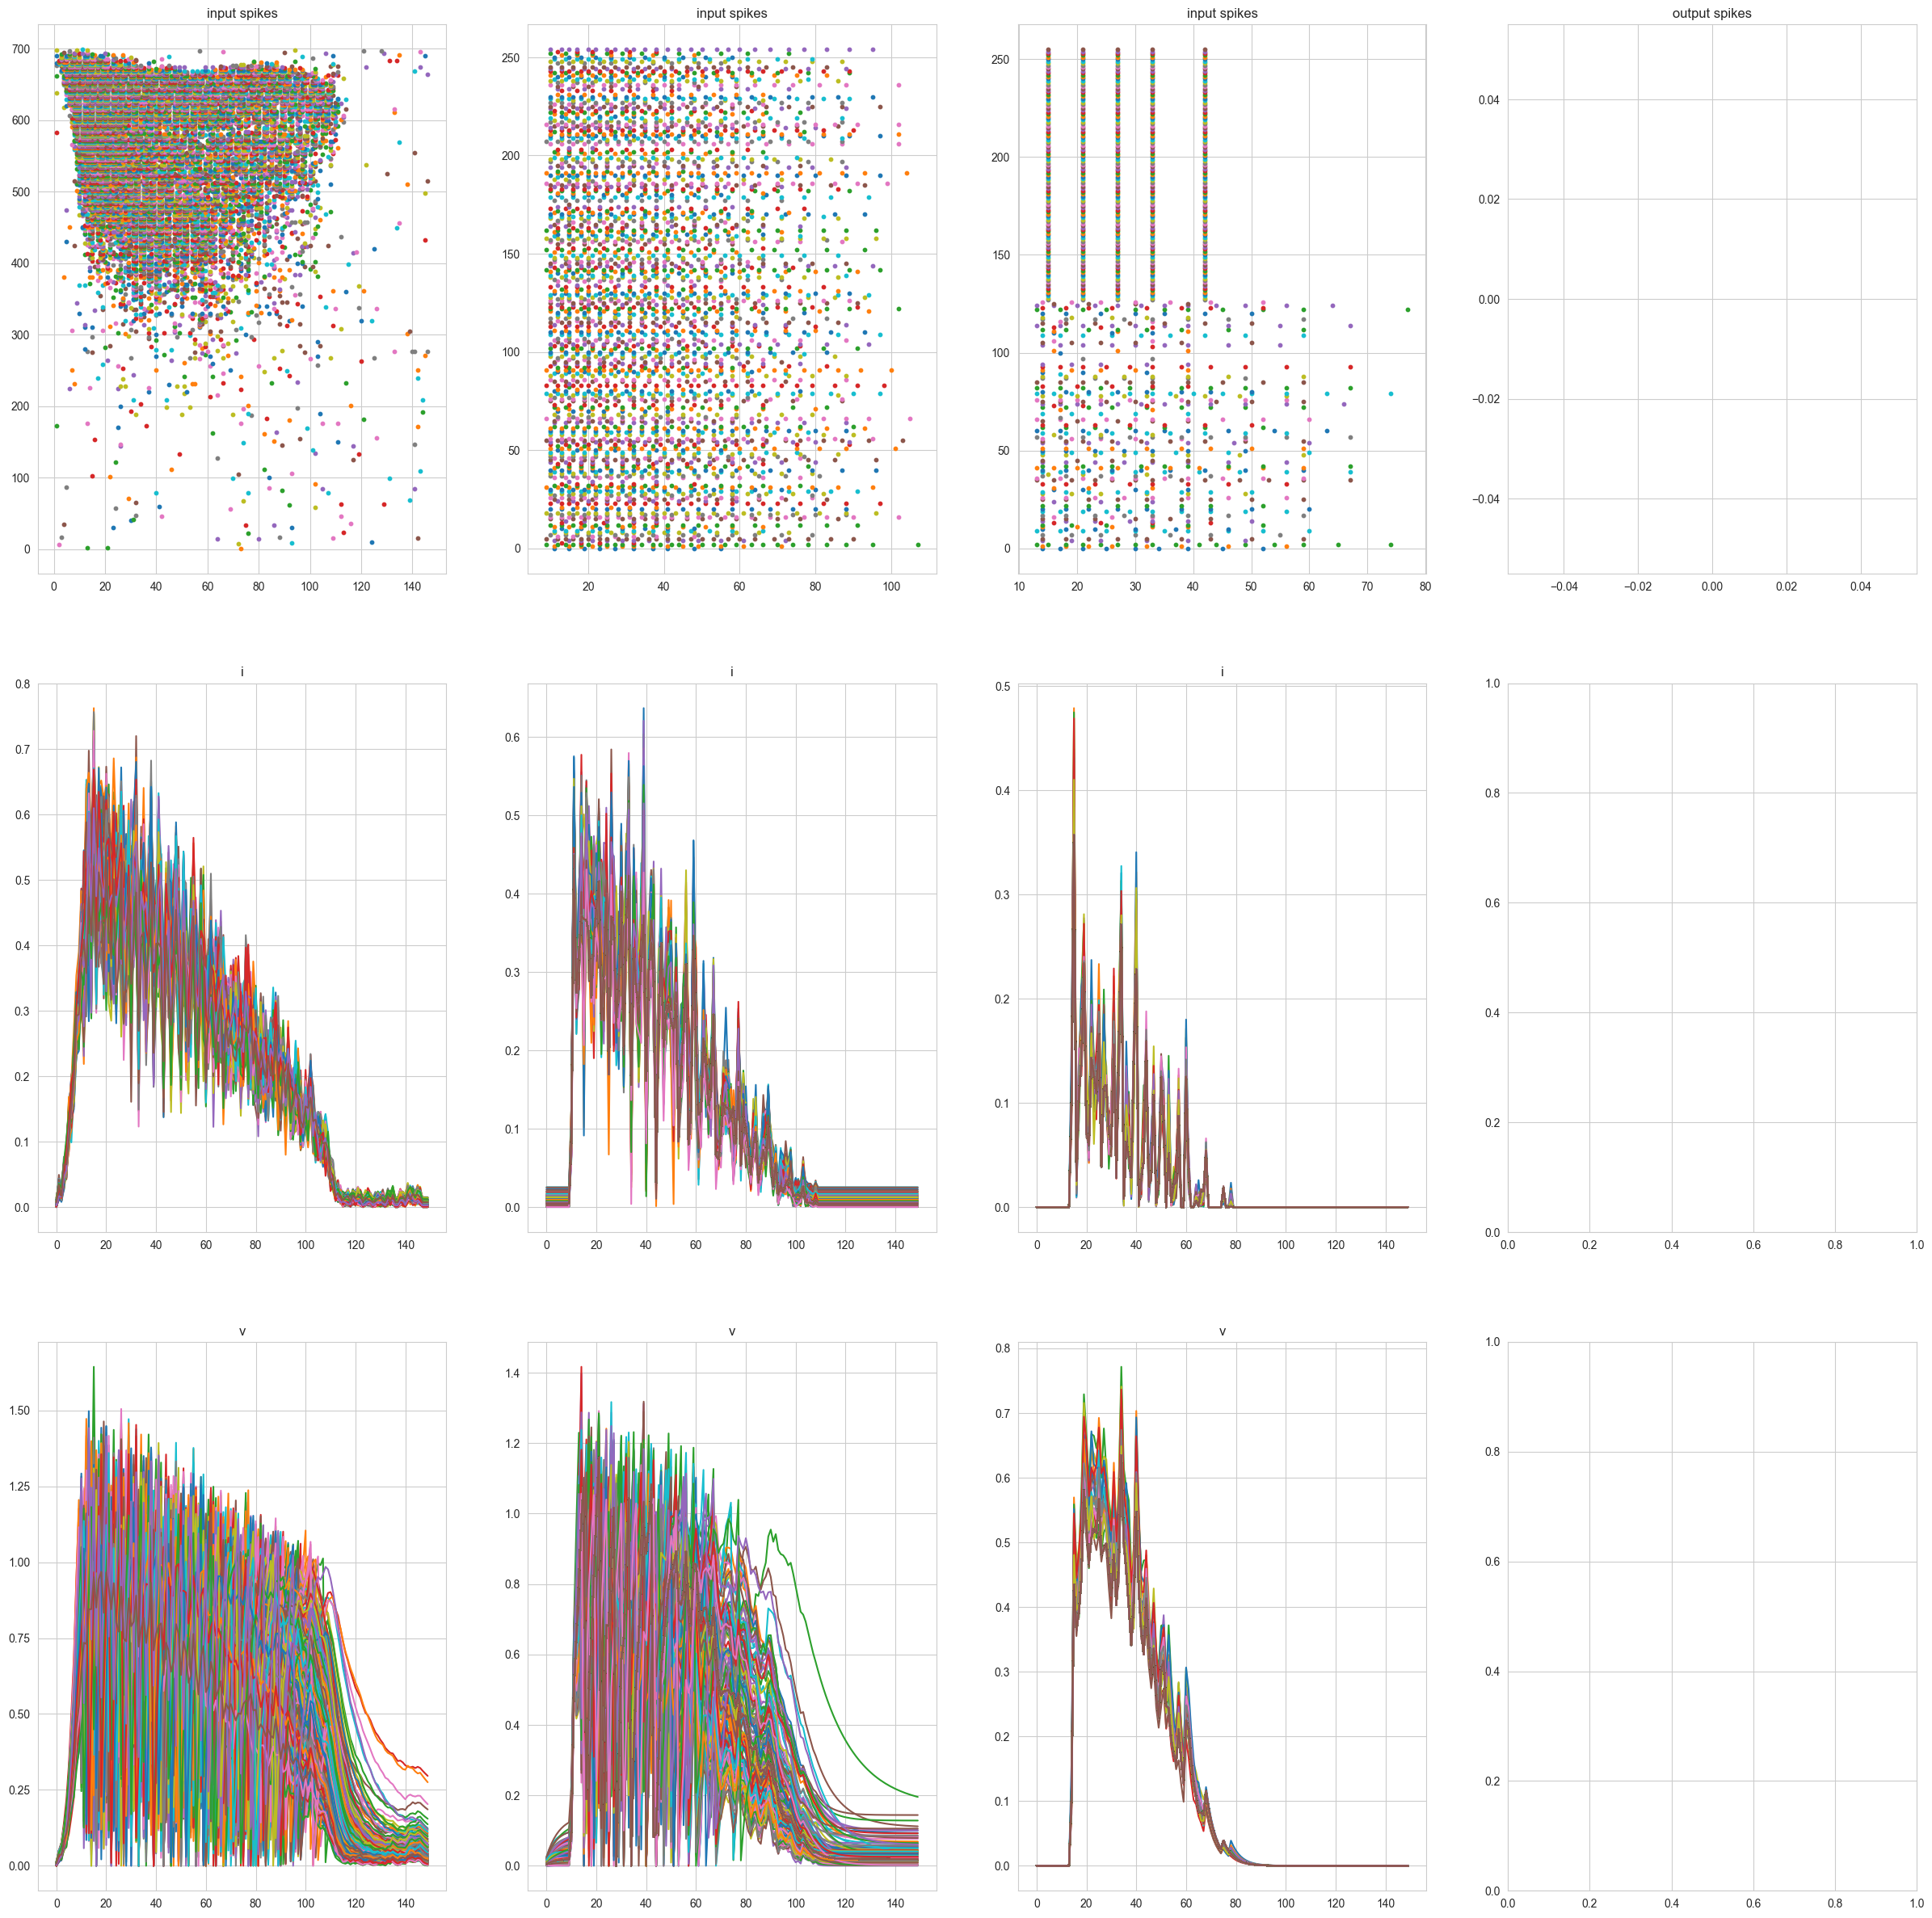

In [10]:
from utils import run_batch, run_inference

def plot_inference(p):
    jax.clear_caches()
    net_dyn_hist = run_inference(p, hp, batch0_test)
    print(f'{len(net_dyn_hist)=}')
    print(f'{len(net_dyn_hist[0])=}, net_dyn_hist[0][0].shape={net_dyn_hist[0][0].shape}')
    # plot i, v, z for first sample
    import matplotlib.pyplot as plt
    sample_id = 0
    fig, ax = plt.subplots(3, 4, figsize=(30, 30))
    t = jnp.arange(150)
    for k in range(3): # loop over layers
        for i in range(2): # loop over i, v
            for j in range(256):
                ax[i+1,k].plot(t, net_dyn_hist[k][i][sample_id,:,j])
            ax[i+1, k].set_title(f'{["i", "v"][i]}')
        ax[0,k].set_title('input spikes')
        
        # plot z 
        if k == 0:    
            for j in range(700):
                ax[0, k].scatter(t, jnp.where(in_spikes_test_batch0[sample_id, :, j] == 0, jnp.nan, 1) * j, s=10, label=f'{j}')
        else: 
            for j in range(256):
                ax[0, k].scatter(t, jnp.where(net_dyn_hist[k-1][2][sample_id, :, j] == 0, jnp.nan, 1) * j, s=10, label=f'{j}')
    
    # plot output spike train in ax[0, 3]
    for j in range(20):
        ax[0, 3].scatter(t, jnp.where(net_dyn_hist[-1][2][sample_id, :, j] == 0, jnp.nan, 1) * j, s=10, label=f'{j}')
    ax[0, 3].set_title('output spikes')
    plt.show()
    
    
plot_inference(params_init)


In [11]:
# leaves = jax.tree_util.tree_leaves(opt_state)
# print(f"opt_state has {len(leaves)} leaves: {leaves}")

In [12]:
loaders = (train_loader, val_loader, test_loader)
first_exec = True 
if first_exec:
    args.nb_epochs = 5
    get_params, opt_state, hist = train(params_init, hp, loaders, args)
    params_trained = get_params(opt_state)

Epoch |Loss      |Acc       |Val Acc   |Test Acc  |Val Loss  |Test Loss 
------|----------|----------|----------|----------|----------|----------
0     |2.8460    |0.0996    |0.1256    |0.1205    |2.7453    |2.7189    
1     |2.6186    |0.1564    |0.1875    |0.1781    |2.4432    |2.4487    
2     |2.3650    |0.2152    |0.2344    |0.2558    |2.2711    |2.2410    
3     |2.1666    |0.2591    |0.2512    |0.2629    |2.1171    |2.1193    
4     |2.0690    |0.2686    |0.2744    |0.2576    |2.0684    |2.1252    
4     |          |          |          |0.2576    |          |2.1252    


bias_enable=True, alpha_enable=False, output_reset=True, hey
layer_id=0
rec
layer_id=1
zero
rec
layer_id=2
zero
two
last
len(net_dyn_hist)=3
len(net_dyn_hist[0])=3, net_dyn_hist[0][0].shape=(64, 150, 256)


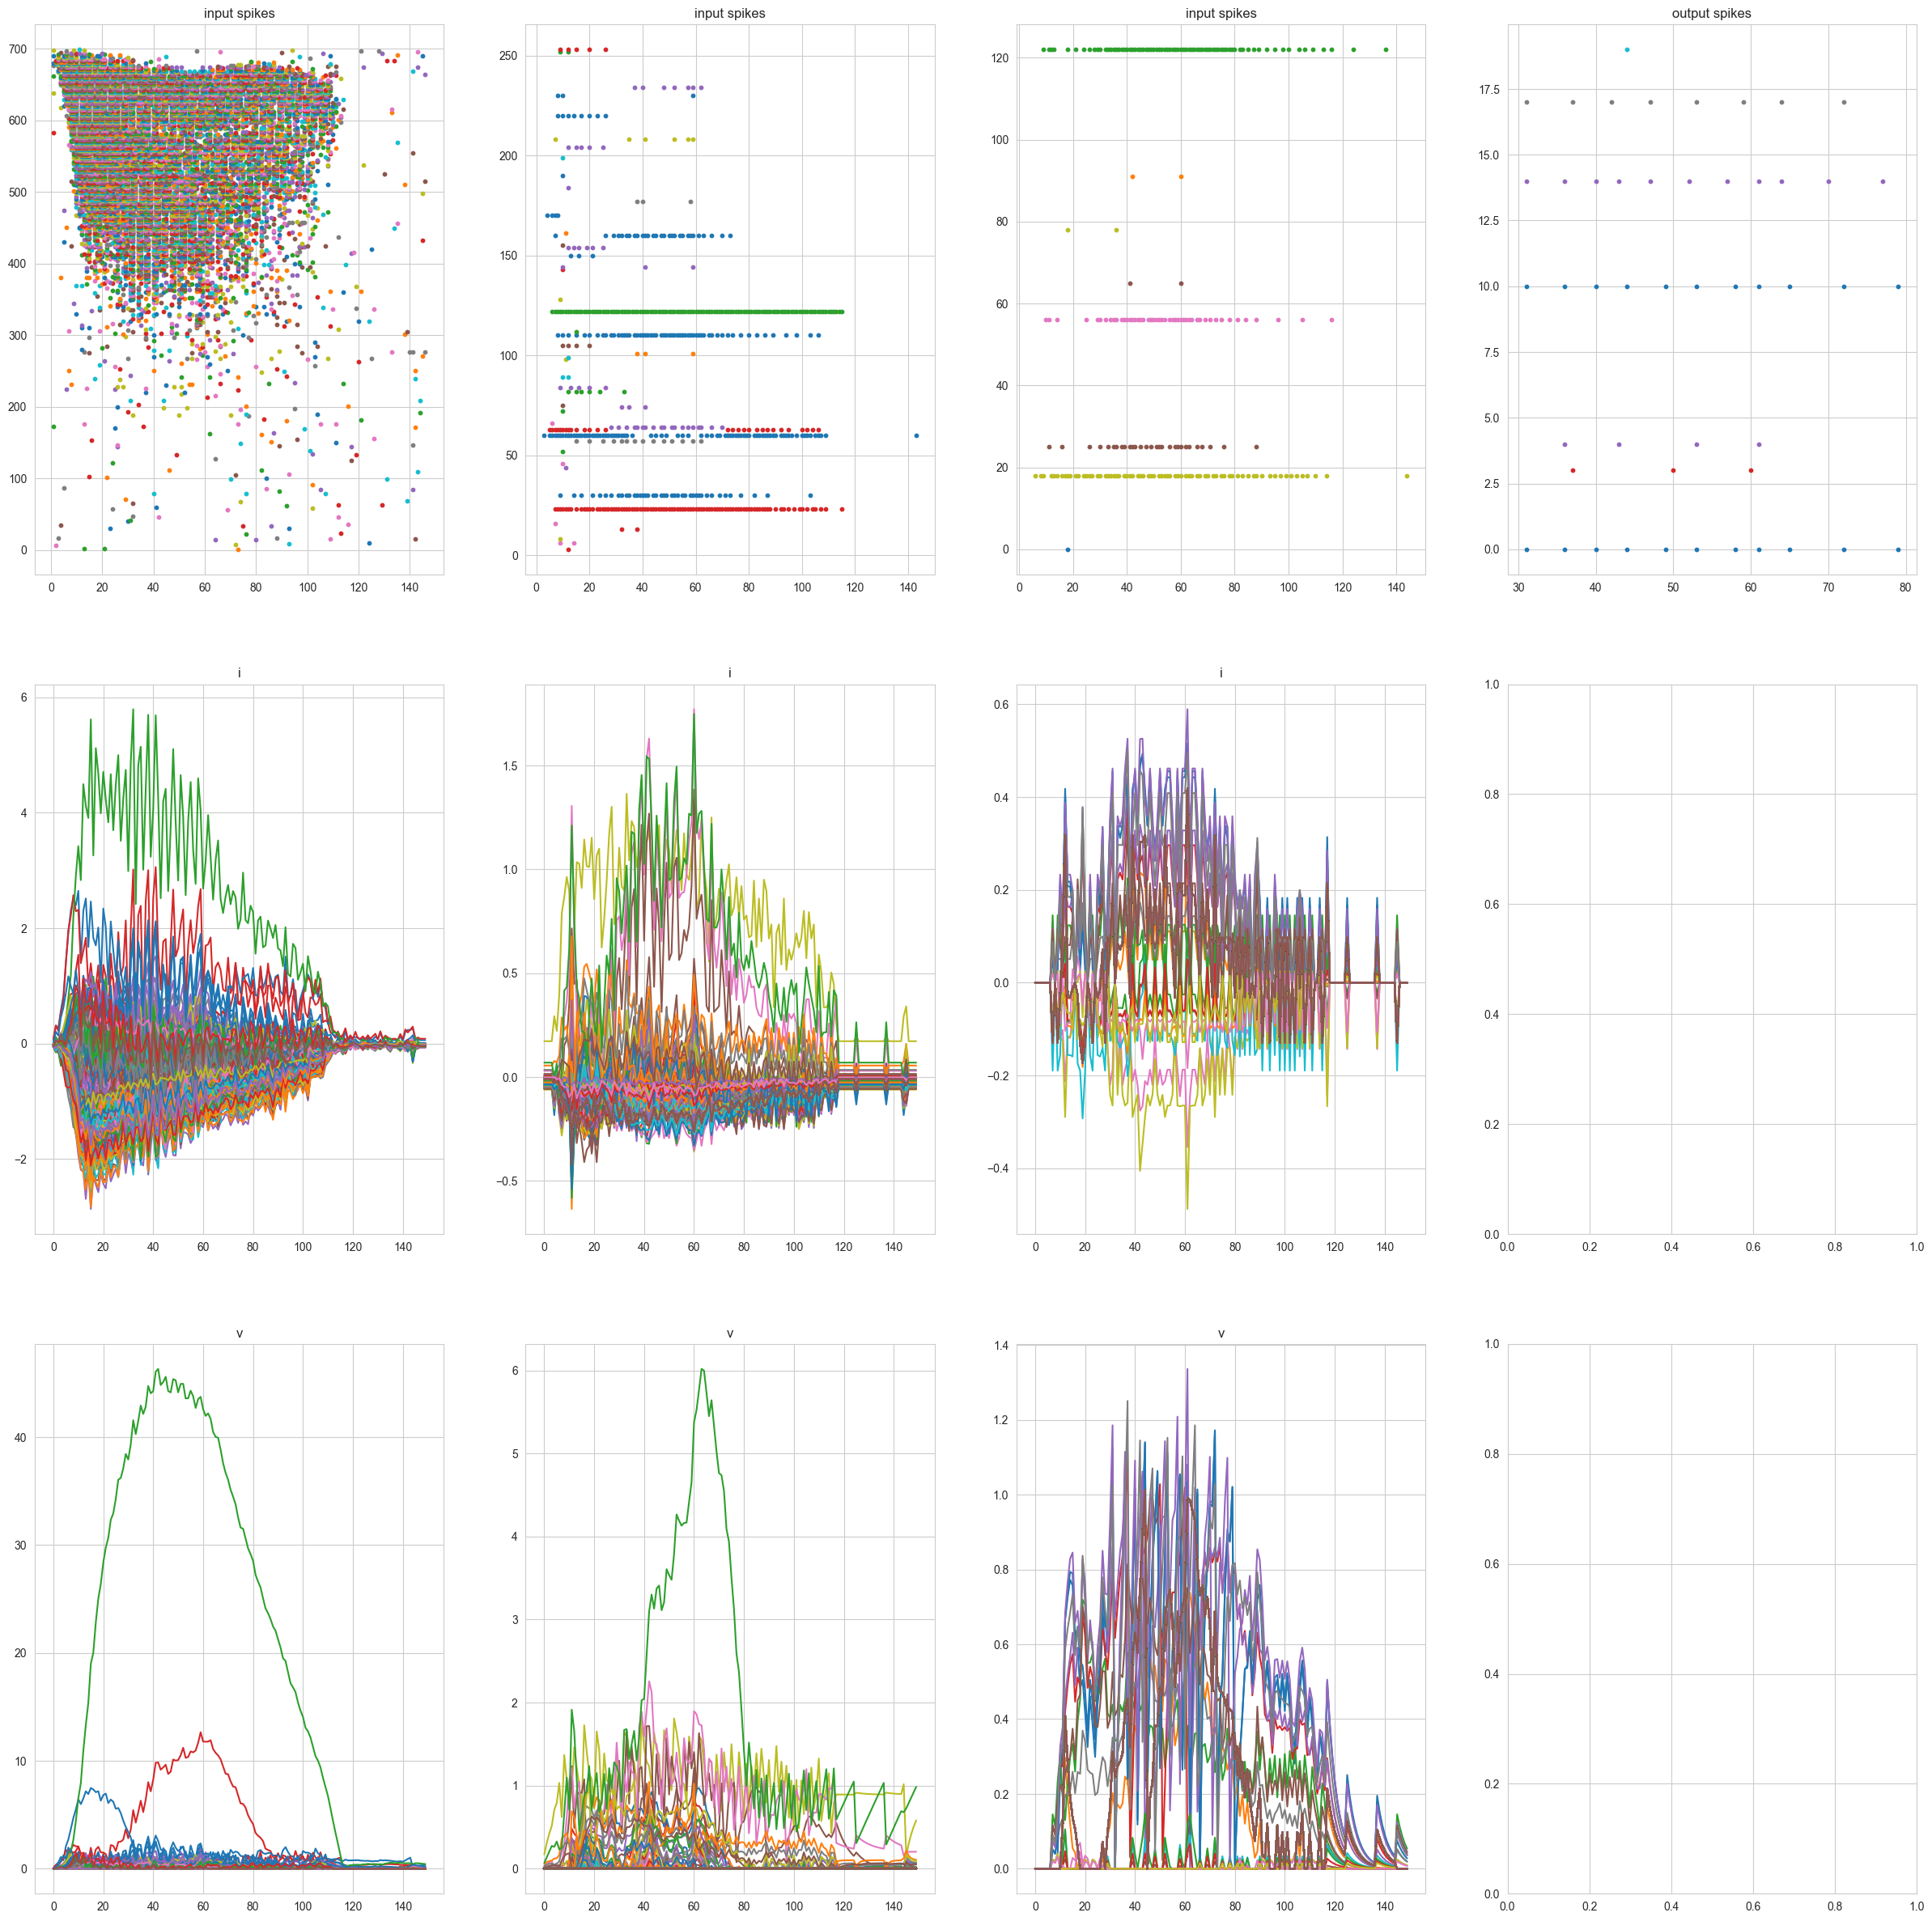

In [13]:
plot_inference(params_trained)

In [14]:
ts_init = params_init[0][-2]
ts_trained = params_trained[0][-2]
print(f'{jnp.array_equal(ts_init, ts_trained)=}')

jnp.array_equal(ts_init, ts_trained)=Array(True, dtype=bool)


In [15]:
tm_init = params_init[0][-1]
tm_trained = params_trained[0][-1]
print(f'{jnp.array_equal(tm_init, tm_trained)=}')

jnp.array_equal(tm_init, tm_trained)=Array(False, dtype=bool)


In [16]:
import matplotlib.pyplot as plt
def plot_params_dist(ps):

    n_rows = len(ps[0])
    n_cols = len(ps[0][0])
    n_bin = 50
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))

    for id_p, p in enumerate(ps):
        colors = ['C1', 'C0']
        for layer_id, layer in enumerate(p):
            axs[layer_id, 0].hist(layer[0].flatten(), bins=n_bin, density=True, color=colors[id_p], alpha=0.5)
            axs[layer_id, 0].set_title(f'Layer {layer_id+1}: Win')
            if layer_id == n_rows-1:
                break
            axs[layer_id, 1].hist(layer[1].flatten(), bins=n_bin, density=True, color=colors[id_p], alpha=0.5)
            axs[layer_id, 1].set_title(f'Layer {layer_id+1}: Wrec')
            if n_cols == 5:
                axs[layer_id, 2].hist(layer[2], bins=n_bin, density=True, color=colors[id_p], alpha=0.5)
                axs[layer_id, 2].set_title(f'Layer {layer_id+1}: Wb')
            axs[layer_id, -2].hist(layer[-2], bins=n_bin, density=True, color=colors[id_p], alpha=0.5)
            axs[layer_id, -2].set_title(f'Layer {layer_id+1}: tau_syn')
            axs[layer_id, -1].hist(layer[-1], bins=n_bin, density=True, color=colors[id_p], alpha=0.5)
            axs[layer_id, -1].set_title(f'Layer {layer_id+1}: tau_mem')

    plt.tight_layout()
    plt.show()

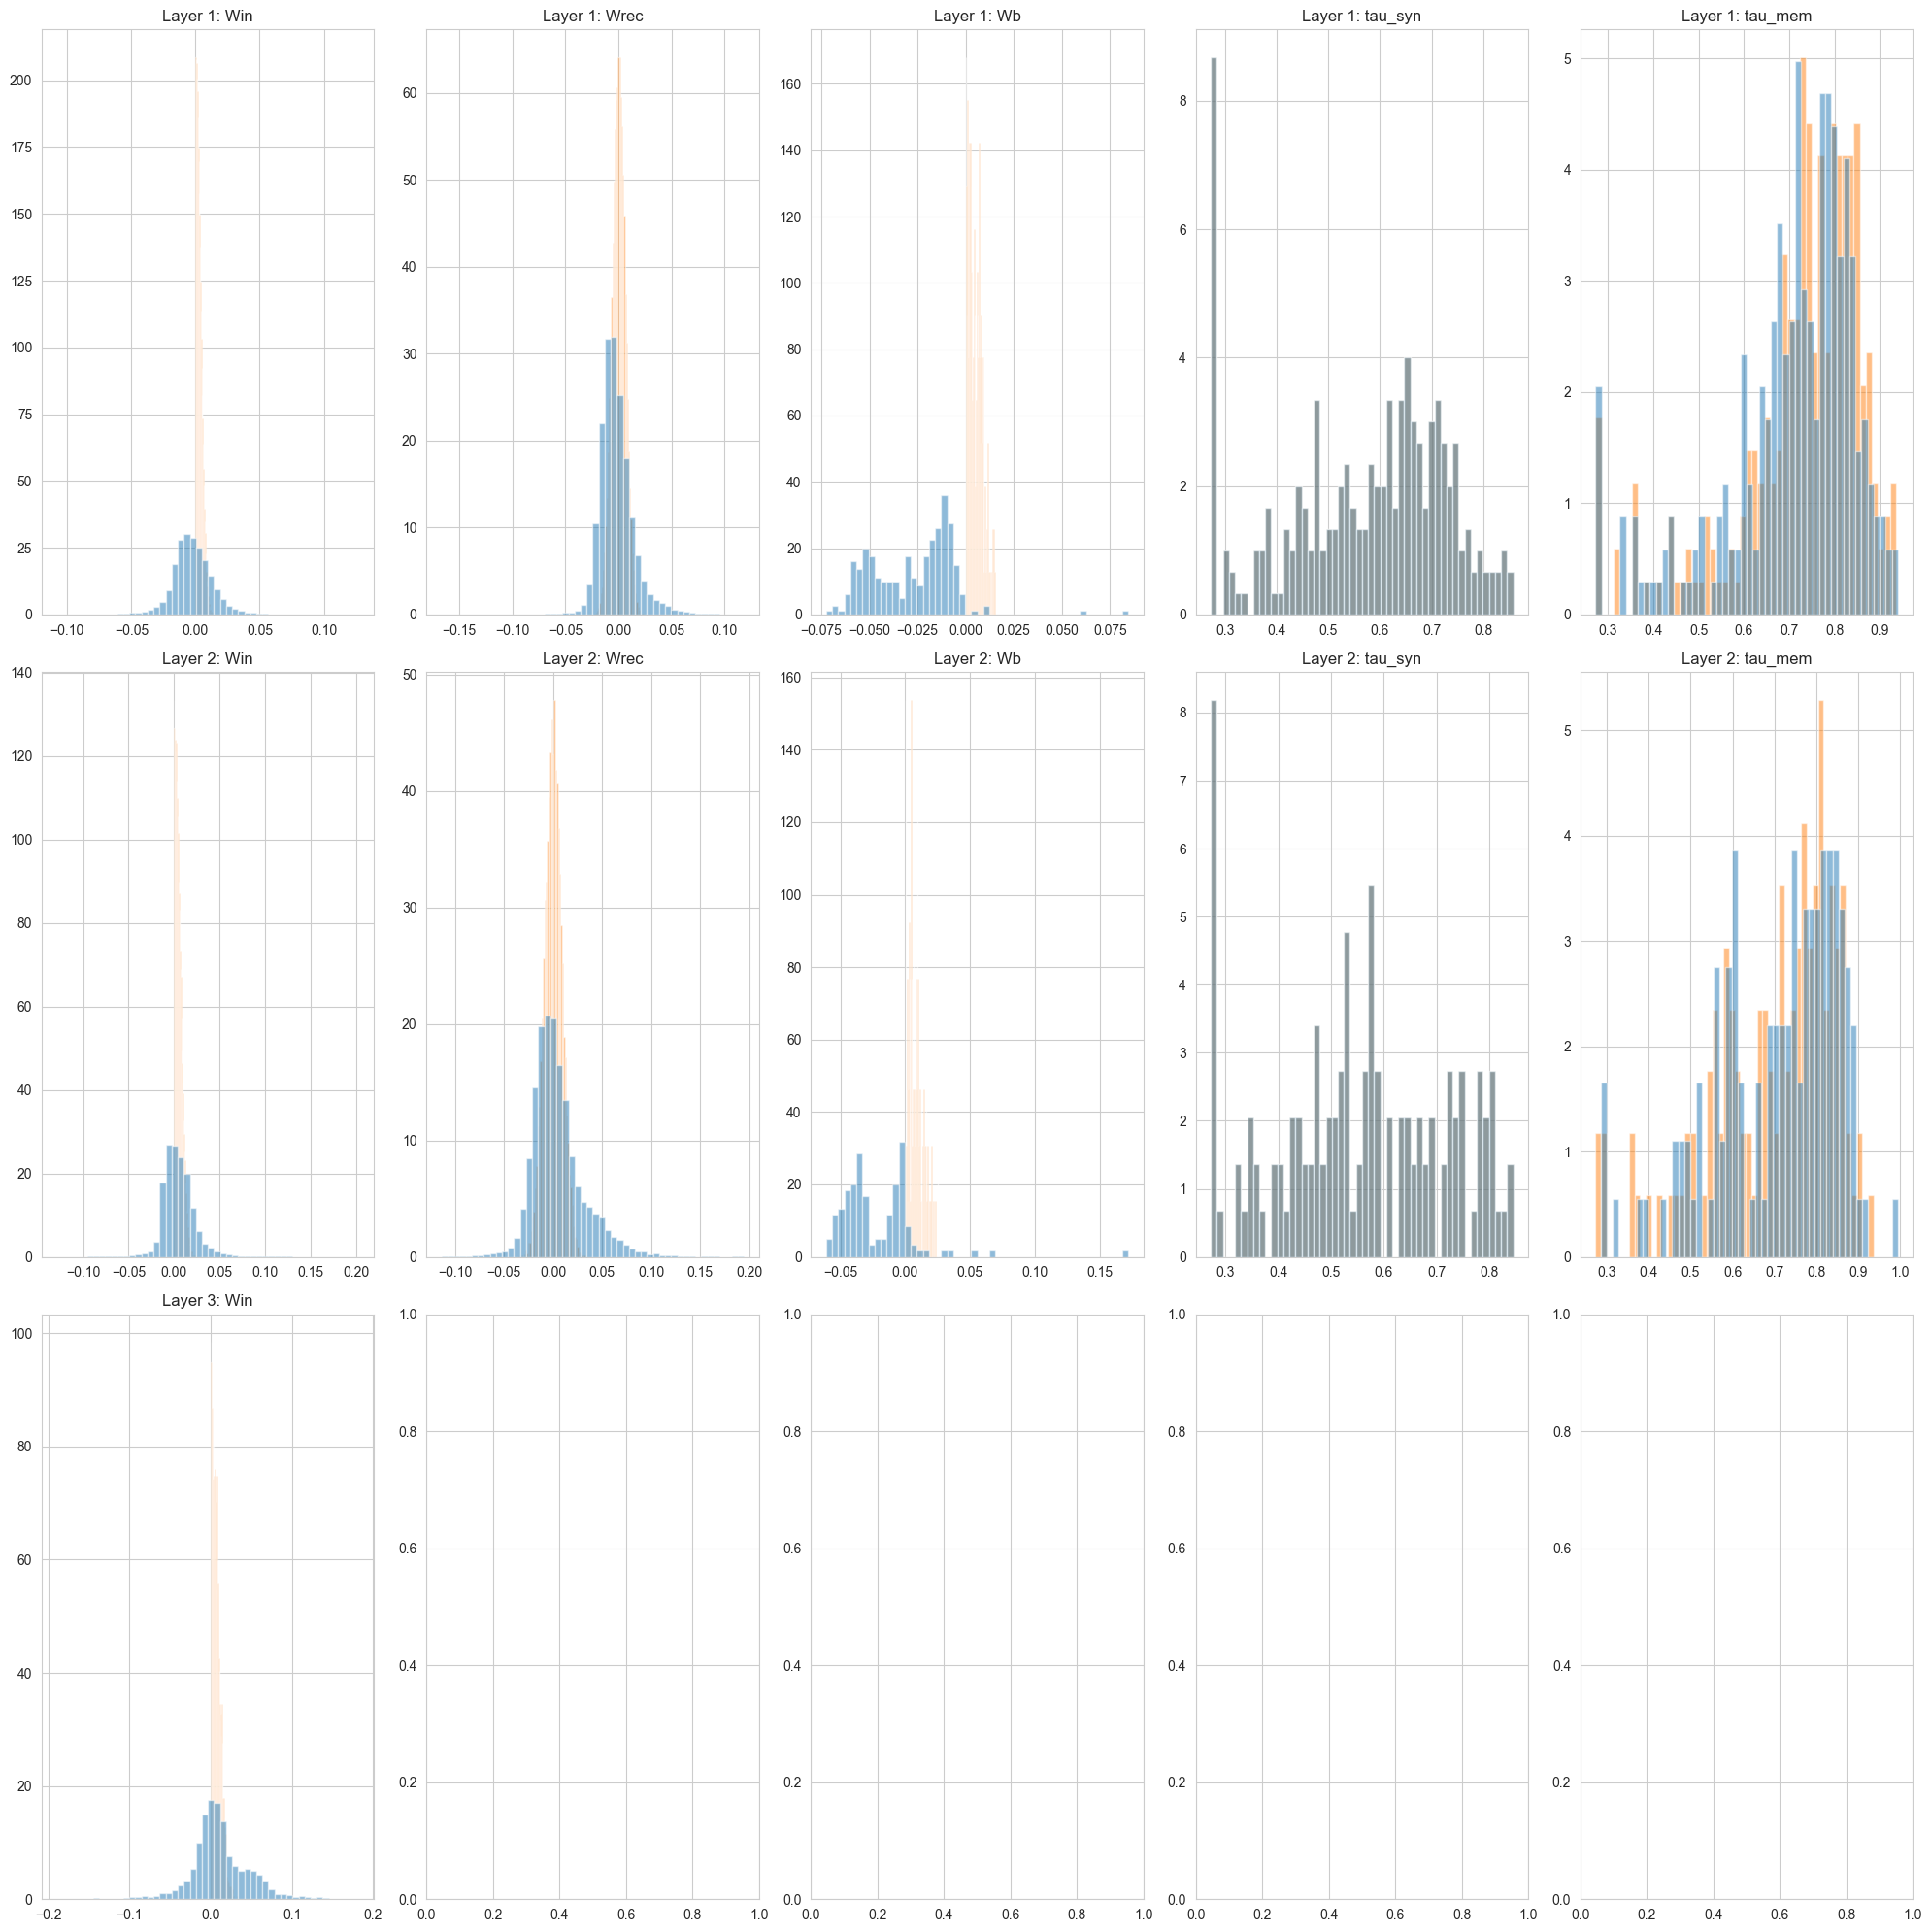

In [17]:
plot_params_dist([params_init, params_trained])
